## Mimic3 Demo

[Mimic3](https://www.kaggle.com/datasets/asjad99/mimiciii) is a large open-access anonymized single-center database which consists of comprehensive clinical data of 61,532 critical care admissions from 2001–2012 collected at a Boston teaching hospital. Dataset consists of 47 features (including demographics, vitals, and lab test results) on a cohort of sepsis patients who meet the sepsis-3 definition criteria.

Due to the privacy concerns, we utilized a subset of he original Mimic3 data that is publicly available on Kaggle. For illustration purpose, we selected several representative features for the following analysis:

*   **Glucose**: glucose values of patients
*   **paO2**: The partial pressure of oxygen
*   **PaO2_FiO2**: The partial pressure of oxygen (PaO2)/fraction of oxygen delivered (FIO2) ratio.
*   **SOFA**: Sepsis-related Organ Failure Assessment score to describe organ dysfunction/failure.
*   **iv-input**: the volumn of fluids that have been administered to the patient.
*   **died_within_48h_of_out_time**:  the mortality status of the patient after 48 hours of being administered.

In the next sections, we will start from causal discovery learning to learn significant causal diagram from the data, and then quantify the effect of treatment ('iv_input') on the outcome (mortality status, denoted by 'died_within_48h_of_out_time' variable in the data) through causal effect learning.

## Causal Discovery Learning

In [1]:
%load_ext autoreload
%autoreload 2

##### Import Packages 
from utils import *
from notear import *
  
from numpy.random import randn
from random import seed as rseed
from numpy.random import seed as npseed

import numpy as np
import pandas as pd
import os
import pickle
import random
import math
import time 

from datetime import datetime

import matplotlib.pyplot as plt

from multiprocessing import Pool
 
from tqdm import tqdm
from functools import partial 

os.environ["OMP_NUM_THREADS"] = "1"

In [36]:
mimic3 = pd.read_csv("subset_rl_data_final_cont.csv")

In [37]:
mimic3_base = mimic3[['icustayid', 'Glucose','paO2','PaO2_FiO2',
                           'iv_input', 'SOFA','died_within_48h_of_out_time']].copy()
mimic3_base['died_within_48h_of_out_time'] = - 2 * np.array(mimic3_base['died_within_48h_of_out_time']) + 1
mimic3_base.columns = ['icustayid', 'Glucose','paO2','PaO2_FiO2',
                           'IV Input', 'SOFA','Died within 48H']
mimic3_base.head(6)

,icustayid,Glucose,paO2,PaO2_FiO2,IV Input,SOFA,Died within 48H
0,1006,91.000,103.000000,206.000000,0.0,8,-1
1,1006,91.000,103.000000,206.000000,0.0,8,-1
2,1006,175.000,96.000000,100.173913,3.0,3,-1
3,1006,175.000,96.000000,96.000000,3.0,10,-1
4,1006,175.000,96.000000,96.000000,4.0,9,-1
5,1006,136.625,113.428571,148.758782,3.0,14,-1


In [38]:
with open('mimic3_multi_stages.pickle', 'wb') as handle:
    pickle.dump(mimic_final, handle)
    
mimic_final.to_csv (r'mimic3_multi_stages.csv', index = False, header=True)

mimic_final.head(6)

,icustayid,Glucose,paO2,PaO2_FiO2,IV Input,SOFA,Died within 48H
0,1006,91.0,103.0,206.000000,0.0,8,-1
1,1006,91.0,103.0,206.000000,0.0,8,-1
2,1006,175.0,96.0,100.173913,3.0,3,-1
3,1006,175.0,96.0,96.000000,3.0,10,-1
4,1006,175.0,96.0,96.000000,4.0,9,-1
6,1006,144.0,110.0,187.234036,4.0,12,-1


In [39]:
# ----------- Set lag data
lag_k = 1
    
#     new_sofa = list(np.array(mimic_final['SOFA'][lag_k:]) - np.array(mimic_final['SOFA'][:-lag_k]))

new_sofa = np.array(mimic_final['SOFA'][:-lag_k])
mimic3_sample = mimic_final.iloc[lag_k:]
mimic3_sample['SOFA'] = new_sofa
mimic3_data = mimic3_sample.groupby('icustayid').mean().reset_index() 

#     mimic3_data = mimic3_sample 


/var/folders/9j/vb5nb4rd5bx0gr1q5ytx9q600000gn/T/ipykernel_28731/3793710715.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mimic3_sample['SOFA'] = new_sofa


In [40]:
with open('mimic3_single_stage.pickle', 'wb') as handle:
    pickle.dump(mimic3_data, handle)
    
mimic3_data.to_csv (r'mimic3_single_stage.csv', index = False, header=True)


mimic3_data.head(6)

,icustayid,Glucose,paO2,PaO2_FiO2,IV Input,SOFA,Died within 48H
0,1006,152.000000,100.200000,137.081590,2.800000,7.600000,-1.0
1,1204,138.794872,127.782051,430.668956,1.153846,6.153846,1.0
2,4132,129.364286,123.956461,252.883864,3.000000,4.600000,-1.0
3,4201,145.580087,118.083333,539.065657,1.363636,5.818182,1.0
4,5170,174.525000,147.350198,394.616727,2.437500,4.125000,1.0
5,6504,106.081169,88.836364,423.030303,0.363636,5.090909,1.0


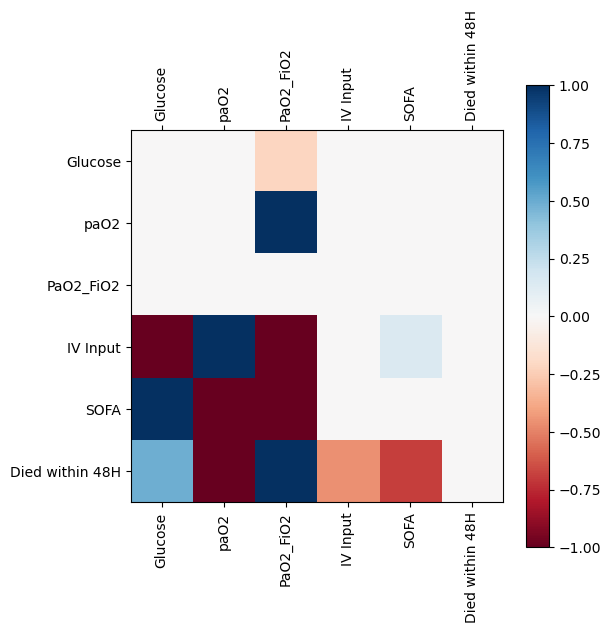

In [17]:
# ----------- Estimated DAG based on NOTEARS

selected = ['Glucose','paO2','PaO2_FiO2', 'IV Input', 'SOFA','Died within 48H']

sample_demo = mimic3_data[selected]
est_mt = notears_linear(np.array(sample_demo), lambda1=0, loss_type='l2',w_threshold=0.1)

# ----------- Plot Associated Matrix for the Estimated DAG based on NOTEARS

plot_mt(est_mt, labels_name=selected, file_name='demo_res_mt')


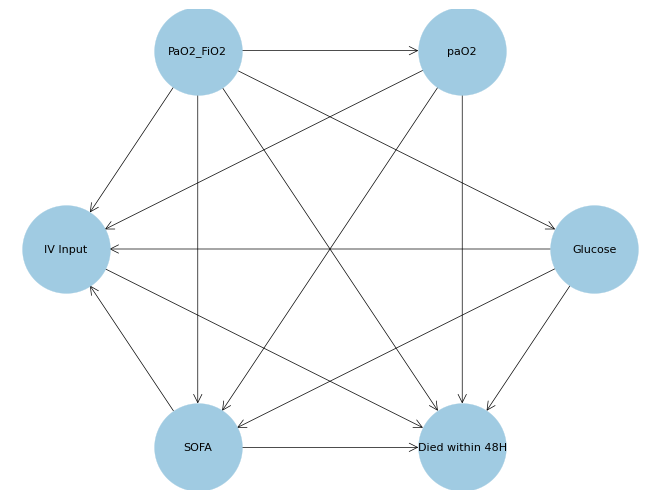

In [18]:
plot_net(est_mt, labels_name=selected, file_name='demo_res_net')



In [19]:
calculate_effect(est_mt)

The total effect (FSTE): [-0.5769399  -1.5085273  38.58722237 -0.46061915 -0.75731054]
The natural direct effect (FSDE): [ 0.48898334 -1.59767349 33.30945388 -0.46061915 -0.69109301]
The natural indirect effect (FSIE): [-1.06592324  0.08914619  5.27776849  0.         -0.06621753]


(array([-0.5769399 , -1.5085273 , 38.58722237, -0.46061915, -0.75731054]),
 array([ 0.48898334, -1.59767349, 33.30945388, -0.46061915, -0.69109301]),
 array([-1.06592324,  0.08914619,  5.27776849,  0.        , -0.06621753]))

## Causal Effect Learning

In [24]:
mimic3_data.columns

Index(['icustayid', 'Glucose', 'paO2', 'PaO2_FiO2', 'IV Input', 'SOFA',
       'Died within 48H'],
      dtype='object')

In [41]:
mimic3_data.head(6)

,icustayid,Glucose,paO2,PaO2_FiO2,IV Input,SOFA,Died within 48H
0,1006,152.000000,100.200000,137.081590,2.800000,7.600000,-1.0
1,1204,138.794872,127.782051,430.668956,1.153846,6.153846,1.0
2,4132,129.364286,123.956461,252.883864,3.000000,4.600000,-1.0
3,4201,145.580087,118.083333,539.065657,1.363636,5.818182,1.0
4,5170,174.525000,147.350198,394.616727,2.437500,4.125000,1.0
5,6504,106.081169,88.836364,423.030303,0.363636,5.090909,1.0


(array([9., 2., 7., 7., 1., 9., 8., 5., 4., 5.]),
 array([0.        , 0.35384615, 0.70769231, 1.06153846, 1.41538462,
        1.76923077, 2.12307692, 2.47692308, 2.83076923, 3.18461538,
        3.53846154]),
 <BarContainer object of 10 artists>)

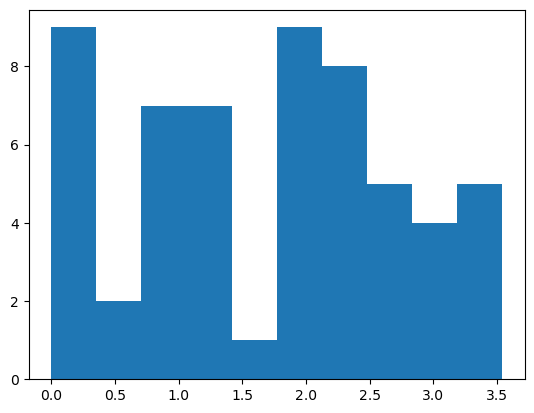

In [49]:
plt.hist(mimic3_data['IV Input'])

In [53]:
len(np.where(mimic3_data['IV Input']>1.5)[0])

32

In [54]:
userinfo_index = np.array([1,2,3,5])
# outcome: Died within 48H (binary)
# treatment: iv_input (binary)
# others: covariates

In [56]:
data_CEL_selected = mimic3_data.copy()
data_CEL_selected.iloc[np.where(data_CEL_selected['IV Input']<=1.5)[0],4]=0 # change the discrete action to binary
data_CEL_selected.iloc[np.where(data_CEL_selected['IV Input']>1.5)[0],4]=1 # change the discrete action to binary

data_CEL_selected.head(6)

,icustayid,Glucose,paO2,PaO2_FiO2,IV Input,SOFA,Died within 48H
0,1006,152.000000,100.200000,137.081590,1.0,7.600000,-1.0
1,1204,138.794872,127.782051,430.668956,0.0,6.153846,1.0
2,4132,129.364286,123.956461,252.883864,1.0,4.600000,-1.0
3,4201,145.580087,118.083333,539.065657,0.0,5.818182,1.0
4,5170,174.525000,147.350198,394.616727,1.0,4.125000,1.0
5,6504,106.081169,88.836364,423.030303,0.0,5.090909,1.0


In [59]:
print(sum(data_CEL_selected.iloc[np.where(data_CEL_selected['IV Input']==0)[0],6]==-1))
print(sum(data_CEL_selected.iloc[np.where(data_CEL_selected['IV Input']==0)[0],6]==1))
print(sum(data_CEL_selected.iloc[np.where(data_CEL_selected['IV Input']==1)[0],6]==-1))
print(sum(data_CEL_selected.iloc[np.where(data_CEL_selected['IV Input']==1)[0],6]==1))
# 58 patients in total

1
24
8
24


In [68]:
#from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

#mu0 = GradientBoostingClassifier(max_depth=2)
#mu1 = GradientBoostingClassifier(max_depth=2)

mu0 = LogisticRegression()
mu1 = LogisticRegression()

mu0.fit(data_CEL_selected.iloc[np.where(data_CEL_selected['IV Input']==0)[0],userinfo_index],data_CEL_selected.iloc[np.where(data_CEL_selected['IV Input']==0)[0],6] )
mu1.fit(data_CEL_selected.iloc[np.where(data_CEL_selected['IV Input']==1)[0],userinfo_index],data_CEL_selected.iloc[np.where(data_CEL_selected['IV Input']==1)[0],6] )


# estimate the HTE by T-learner
HTE_T_learner = (mu1.predict_proba(data_CEL_selected.iloc[:,userinfo_index]) - mu0.predict_proba(data_CEL_selected.iloc[:,userinfo_index]))[:,1]

In [69]:
HTE_T_learner

array([-6.12968636e-01, -2.19898149e-02, -2.24396566e-01, -1.43603356e-03,
       -2.31089138e-02, -4.21971678e-03, -1.06065978e-01, -1.82908445e-01,
       -1.29373902e-02, -1.57378496e-03, -3.80665075e-01, -7.19204846e-02,
       -5.87878672e-04, -1.64194759e-02, -3.74329403e-02, -2.99208870e-01,
       -4.05536722e-01, -3.93997356e-01, -1.37658583e-01, -6.30516698e-02,
       -4.69053614e-02, -5.25454412e-02, -8.90354918e-02, -1.84492112e-01,
        6.74707375e-01, -3.99243862e-01, -3.32124499e-01, -1.76639796e-01,
       -3.81722590e-01, -3.36737950e-01, -7.48175640e-01, -7.16482878e-02,
       -5.83113927e-01, -2.46330508e-01, -6.02204099e-04, -8.14829020e-03,
       -1.10124807e-02, -3.05696535e-02, -2.95670546e-01, -1.12886177e-01,
       -8.77514502e-03, -1.98200718e-01, -1.50224457e-01, -1.93376762e-02,
       -3.25920083e-01, -8.61056677e-01, -2.69004260e-01, -1.71707357e-02,
       -6.38961340e-01, -2.80770800e-02, -1.64875651e-01, -2.62006664e-01,
       -3.24956862e-01, -

In [70]:
mu1.predict(data_CEL_selected.iloc[:,userinfo_index])

array([-1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1., -1.,  1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1., -1.,  1.,  1., -1.,  1.,  1.,  1.,
        1.,  1.,  1., -1., -1.])

In [71]:
mu0.predict(data_CEL_selected.iloc[:,userinfo_index])

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.])

In [74]:
np.where(mu1.predict(data_CEL_selected.iloc[:,userinfo_index])-mu0.predict(data_CEL_selected.iloc[:,userinfo_index])==-2)[0]

array([ 0, 30, 32, 45, 48, 55, 56])

In [73]:
sum(HTE_T_learner)/len(data_CEL_selected)

-0.19737465540314486

**Conclusion**: iv-input is expected to improve the death-within-48-hours rate by 19.74%.

### exclude SOFA from the covariates list

In [75]:
userinfo_index = np.array([1,2,3])

#from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

#mu0 = GradientBoostingClassifier(max_depth=2)
#mu1 = GradientBoostingClassifier(max_depth=2)

mu0 = LogisticRegression()
mu1 = LogisticRegression()

mu0.fit(data_CEL_selected.iloc[np.where(data_CEL_selected['IV Input']==0)[0],userinfo_index],data_CEL_selected.iloc[np.where(data_CEL_selected['IV Input']==0)[0],6] )
mu1.fit(data_CEL_selected.iloc[np.where(data_CEL_selected['IV Input']==1)[0],userinfo_index],data_CEL_selected.iloc[np.where(data_CEL_selected['IV Input']==1)[0],6] )


# estimate the HTE by T-learner
HTE_T_learner = (mu1.predict_proba(data_CEL_selected.iloc[:,userinfo_index]) - mu0.predict_proba(data_CEL_selected.iloc[:,userinfo_index]))[:,1]

In [76]:
HTE_T_learner

array([-0.42850795, -0.04122985, -0.37054069, -0.0055272 , -0.10384686,
       -0.01457029, -0.16909439, -0.28221447, -0.05764574, -0.008193  ,
       -0.30211856, -0.0551675 , -0.01006845, -0.09689565, -0.10600407,
       -0.18238777, -0.44978522, -0.19716563, -0.289073  , -0.03827421,
       -0.22619666, -0.1875545 , -0.23778146, -0.20841167,  0.73958005,
       -0.11909299, -0.09661241, -0.15624675, -0.3466977 , -0.42682439,
       -0.353852  , -0.12244475, -0.53581201, -0.38763738, -0.00624024,
       -0.02708992, -0.08227609, -0.09644005, -0.19550407, -0.30207966,
       -0.03525717, -0.34339108, -0.30668368, -0.11740263, -0.23538089,
       -0.41147115, -0.46029296, -0.10346963, -0.51161134, -0.04498817,
       -0.18302802, -0.21907476, -0.54002382, -0.23518752, -0.06635588,
       -0.83090637, -0.3999141 ])

In [77]:
mu1.predict(data_CEL_selected.iloc[:,userinfo_index])

array([-1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -1.,  1.,  1.,  1.,
       -1.,  1.,  1., -1.,  1.])

In [78]:
mu0.predict(data_CEL_selected.iloc[:,userinfo_index])

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.])

In [79]:
np.where(mu1.predict(data_CEL_selected.iloc[:,userinfo_index])-mu0.predict(data_CEL_selected.iloc[:,userinfo_index])==-2)[0]

array([ 0, 32, 48, 52, 55])

In [80]:
sum(HTE_T_learner)/len(data_CEL_selected)

-0.20399937380848096

**Conclusion**: iv-input is expected to improve the death-within-48-hours rate by 20.40%.

### Regard SOFA as outcome variable

In [82]:
userinfo_index = np.array([1,2,3])
# outcome: SOFA score (treated as continuous). The smaller, the better
# treatment: iv_input (binary)
# others: covariates
data_CEL_selected.head(6)

,icustayid,Glucose,paO2,PaO2_FiO2,IV Input,SOFA,Died within 48H
0,1006,152.000000,100.200000,137.081590,1.0,7.600000,-1.0
1,1204,138.794872,127.782051,430.668956,0.0,6.153846,1.0
2,4132,129.364286,123.956461,252.883864,1.0,4.600000,-1.0
3,4201,145.580087,118.083333,539.065657,0.0,5.818182,1.0
4,5170,174.525000,147.350198,394.616727,1.0,4.125000,1.0
5,6504,106.081169,88.836364,423.030303,0.0,5.090909,1.0


In [84]:
#from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression

#mu0 = LGBMRegressor(max_depth=2)
#mu1 = LGBMRegressor(max_depth=2)

mu0 = LinearRegression()
mu1 = LinearRegression()

mu0.fit(data_CEL_selected.iloc[np.where(data_CEL_selected['IV Input']==0)[0],userinfo_index],data_CEL_selected.iloc[np.where(data_CEL_selected['IV Input']==0)[0],5] )
mu1.fit(data_CEL_selected.iloc[np.where(data_CEL_selected['IV Input']==1)[0],userinfo_index],data_CEL_selected.iloc[np.where(data_CEL_selected['IV Input']==1)[0],5] )


# estimate the HTE by T-learner
HTE_T_learner = (mu1.predict(data_CEL_selected.iloc[:,userinfo_index]) - mu0.predict(data_CEL_selected.iloc[:,userinfo_index]))

In [85]:
mu1.predict(data_CEL_selected.iloc[:,userinfo_index])

array([6.20534783, 5.60799131, 6.03101525, 5.30487613, 5.73901719,
       5.50869865, 5.93409258, 6.06268418, 5.62814712, 5.33088885,
       6.06805273, 5.85343431, 5.3891968 , 5.77059072, 5.85723926,
       5.90852121, 6.16255577, 5.73226175, 6.0713091 , 5.61008793,
       5.84837405, 5.73072933, 5.96310458, 5.69542996, 6.06679508,
       5.80242966, 5.75052079, 5.89086905, 6.0049731 , 6.05624172,
       6.05820508, 5.80224073, 6.08963454, 6.0349788 , 5.01483998,
       5.63905221, 5.74432509, 5.78090422, 5.99109928, 5.95093155,
       5.67313649, 6.06334448, 6.05130982, 5.86413964, 5.79011822,
       6.13613724, 6.05677335, 5.77466503, 5.82624963, 5.71759965,
       5.87293765, 5.95941413, 5.81655015, 6.00536321, 5.70841914,
       6.24891247, 6.12551622])

In [86]:
 mu0.predict(data_CEL_selected.iloc[:,userinfo_index])

array([6.6953789 , 5.10741154, 5.82186952, 4.6414173 , 5.97879022,
       4.42927105, 6.27864757, 7.42377512, 4.42966655, 4.75082494,
       7.1816504 , 9.08880529, 5.57819536, 5.1209202 , 5.22000112,
       5.85809935, 6.42621801, 5.72353439, 6.40045611, 5.09534446,
       5.43170283, 5.18914595, 5.24989338, 4.43053592, 7.14426689,
       5.28013788, 5.13285216, 5.31529729, 5.05722861, 5.50437684,
       6.35486627, 5.44263627, 5.88826623, 5.26089302, 3.8225689 ,
       5.52442018, 8.10365132, 6.07635828, 7.85447013, 4.99921777,
       5.06040788, 6.05859007, 5.99065991, 6.50620091, 5.03579105,
       5.93077781, 5.68668211, 5.42035374, 5.03808058, 6.48700577,
       5.19118358, 5.2131336 , 4.70773032, 5.83005235, 5.77993266,
       8.07031865, 6.13590299])

In [87]:
HTE_T_learner

array([-0.49003107,  0.50057977,  0.20914573,  0.66345884, -0.23977303,
        1.0794276 , -0.34455499, -1.36109094,  1.19848057,  0.58006391,
       -1.11359767, -3.23537098, -0.18899855,  0.64967052,  0.63723815,
        0.05042186, -0.26366224,  0.00872736, -0.32914701,  0.51474347,
        0.41667122,  0.54158338,  0.71321121,  1.26489405, -1.0774718 ,
        0.52229178,  0.61766863,  0.57557176,  0.94774448,  0.55186488,
       -0.29666119,  0.35960446,  0.20136832,  0.77408578,  1.19227108,
        0.11463203, -2.35932623, -0.29545405, -1.86337085,  0.95171379,
        0.61272862,  0.00475441,  0.06064992, -0.64206127,  0.75432718,
        0.20535944,  0.37009124,  0.35431129,  0.78816905, -0.76940612,
        0.68175408,  0.74628053,  1.10881984,  0.17531085, -0.07151351,
       -1.82140618, -0.01038676])

In [88]:
sum(HTE_T_learner)/len(data_CEL_selected)

0.08642818615808806

**Conclusion**: IV Input is expected to increase the SOFA score by 0.086.